In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.experimental import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu
from jax.config import config
from jax import lax
from jax.flatten_util import ravel_pytree
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/scratch/sifanw/anaconda3/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# MLP

In [2]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

# Data Sampler

In [3]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        y = self.y[idx,:]
        s = self.s[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

# DeepONet

In [4]:
# Define the model
class DeepONet:
    def __init__(self, weights, branch_layers, trunk_layers):  
        
        self.weights = weights
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=relu)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=relu)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.9)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

    # Define the opeartor net
    def operator_net(self, params, u, y):
        branch_params, trunk_params = params
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return outputs
      
    def residual_net(self, params, u, y):
        s_y = grad(self.operator_net, argnums = 2)(params, u, y)
        return s_y
        
    @partial(jit, static_argnums=(0,))
    def compute_NTK(self, params, u, y):
        K = grad(self.operator_net, argnums=0)(params, u, y)
        K, _ = ravel_pytree(K)
        K = np.dot(K, K)
        return K

    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0))(params, u, y)

        # Compute loss
        if self.weights == 'no_weights':
            lam = 1.0
      
        if self.weights == 's_weights':
            # Use available solution measurements to assign weights
            lam = 1 / np.abs(outputs.flatten())
            
        if self.weights == 'NTK_weights':
            K = vmap(self.compute_NTK, (None, 0, 0))(params, u, y)
            K_max = K.max()
            lam = lax.stop_gradient(K_max / K)
        
        if self.weights == 'moderate_NTK_weights':
            K = vmap(self.compute_NTK, (None, 0, 0))(params, u, y)
            K_max = K.max()
            lam = lax.stop_gradient(np.sqrt(K_max / K)) # square root of NTK weights

        loss = np.mean((outputs.flatten() - pred.flatten())**2 * lam)
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                loss_value = self.loss(params, batch)
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})
        
        results = {'state': params,
                   'loss': self.loss_log}
        
        return results
       
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0))(params, U_star, Y_star)
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_s_y(self, params, U_star, Y_star):
        s_y_pred = vmap(self.residual_net, (None, 0, 0))(params, U_star, Y_star)
        return s_y_pred

# Data Generation

In [5]:
def RBF(x1, x2, params):
    output_scale, length_scale = params
    diffs = np.expand_dims(x1 / length_scale, 1) - \
            np.expand_dims(x2 / length_scale, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

def generate_one_training_data(key, m=100, P=1):
    # Sample GP prior at a fine grid
    N = 512
    jitter = 1e-10

    subkeys = random.split(key, 2)
    
    # Randomly sample a output scale from a log uniform distribution
    output_scale = random.uniform(subkeys[0], shape=(1,), minval=-2.0, maxval=2.0).flatten()
    output_scale = np.power(10.0, output_scale)
    gp_params = (output_scale, length_scale)
    
    X = np.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(subkeys[1], (N,)))
    # Create a callable interpolation function  
    u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)
    # Input sensor locations and measurements
    x = np.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)
    # Output sensor locations and measurements

    y_train = random.uniform(key, (P,)).sort() 
    s_train = odeint(u_fn, 0.0, np.hstack((0.0, y_train)))[1:] # JAX has a bug and always returns s(0), so add a dummy entry to y and return s[1:]

    # Tile inputs
    u_train = np.tile(u, (P,1))

    u_r_train = np.tile(u, (m, 1))
    y_r_train = x
    s_r_train = u

    return u_train, y_train, s_train, u_r_train, y_r_train,  s_r_train

def generate_one_test_data(key, gp_params, m=100, P=100):
    # Sample GP prior at a fine grid
    N = 512
    jitter = 1e-10
    X = np.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))
    # Create a callable interpolation function  
    u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)
    # Input sensor locations and measurements
    x = np.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)
    # Output sensor locations and measurements
    y = np.linspace(0, 1, P)
    s = odeint(u_fn, 0.0, y)

    # Tile inputs
    u = np.tile(u, (P,1))

    return u, y, s 

def generate_training_data(key, N, m, P):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)

    gen_fn = jit(lambda key: generate_one_training_data(key, m, P))
    u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = vmap(gen_fn)(keys)

    u_train = np.float32(u_train.reshape(N * P,-1))
    y_train = np.float32(y_train.reshape(N * P,-1))
    s_train = np.float32(s_train.reshape(N * P,-1))

    u_r_train = np.float32(u_r_train.reshape(N * m,-1))
    y_r_train = np.float32(y_r_train.reshape(N * m,-1))
    s_r_train = np.float32(s_r_train.reshape(N * m,-1))

    config.update("jax_enable_x64", False)
    return u_train, y_train, s_train, u_r_train, y_r_train,  s_r_train


def generate_test_data(key, gp_params, N, m, P):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    gen_fn = jit(lambda key: generate_one_test_data(key, gp_params, m, P))
    u, y, s = vmap(gen_fn)(keys)
    u = np.float32(u.reshape(N * P,-1))
    y = np.float32(y.reshape(N * P,-1))
#     s = np.float32(s.reshape(N * P,-1))

    config.update("jax_enable_x64", False)
    return u, y, s


def compute_error(s_pred, s_test):
    error_s = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 
    return error_s


In [6]:
# Generate training data 
N_train = 10000 # number of input functions
m = 100 # number of input sensors
P_train = 1  # number of output sensors
key_train = random.PRNGKey(0) # use different key for generating training data 
length_scale = 0.2 # fix the length scale of GRF

u_train_list = []
y_train_list = []
s_train_list = []

N = 10
for k in range(N):
    u_train, y_train, s_train, _, _, _ = generate_training_data(random.PRNGKey(k), N_train // N, m, P_train)

    u_train_list.append(u_train)
    y_train_list.append(y_train)
    s_train_list.append(s_train)

u_train = np.vstack(u_train_list)
y_train = np.vstack(y_train_list)
s_train = np.vstack(s_train_list)

# Train

In [7]:
# Hyperparameters
weights_scheme = ['no_weights', 's_weights', 'NTK_weights', 'moderate_NTK_weights']
branch_layers = [100, 100, 100]
trunk_layers =  [1, 100, 100]

# Test hyperparameters
N_test = 1000
P_test = m
key_test = random.PRNGKey(12345)
keys_test = random.split(key_test, N_test)
output_scale_list =  np.power(10, np.linspace(-2.0, 2.0, 11))


In [8]:
outputs = {}

for weights in weights_scheme:
    
    # Initialize the model with different weighting schemes
    model = DeepONet(weights, branch_layers, trunk_layers)
    
    # Initialize the datasampler for each train
    batch_size = 10000
    datasampler = DataGenerator(u_train, y_train, s_train, batch_size)
    
    # Train
    results = model.train(datasampler, nIter=40000)
    
    params = model.get_params(model.opt_state)
    
    # Compute errors over different output scales
    error_mean_list = []
    error_std_list = []
    
    for output_scale in output_scale_list:
    
        gp_params = (output_scale, length_scale)
        u_test, y_test, s_test = generate_test_data(key_test, gp_params, N_test, m, P_test)
        s_pred = model.predict_s(params, u_test, y_test).reshape(N_test, -1)
        # Compute errors
        errors = vmap(compute_error, (0, 0))(s_pred, s_test) 
        error_mean_list.append(errors.mean())
        error_std_list.append(errors.std())
    
    results['error_mean'] = error_mean_list
    results['error_std'] = error_std_list
    
    outputs[weights] = results


100%|██████████| 40000/40000 [02:59<00:00, 222.85it/s, Loss=4.003855e-05]  


# Plot

In [9]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                      "text.latex.preamble": r'\usepackage{amsmath}'
                    })


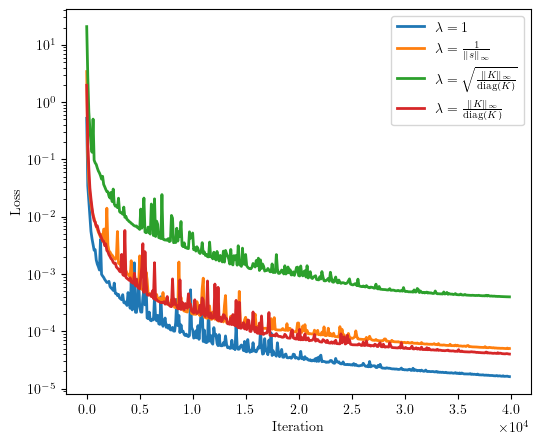

In [10]:
# Weighted loss during training
weights_scheme = ['no_weights', 's_weights', 'NTK_weights', 'moderate_NTK_weights']
labels = ['$\lambda = 1$', 
          '$\lambda = \\frac{1}{\|s\|_{\infty}}$',
          '$\lambda = \sqrt{\\frac{\|K\|_\infty}{ \\text{diag}(K)}}$',
          '$\lambda = \\frac{\|K\|_\infty}{ \\text{diag}(K)}$']


fig = plt.figure(figsize=(6,5))

for k in range(4):
    weights = weights_scheme[k]
    loss = outputs[weights]['loss']
    iters = 100 * np.arange(len(loss))
    
    plt.plot(iters, loss , lw=2,  label=labels[k])
    
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.show()

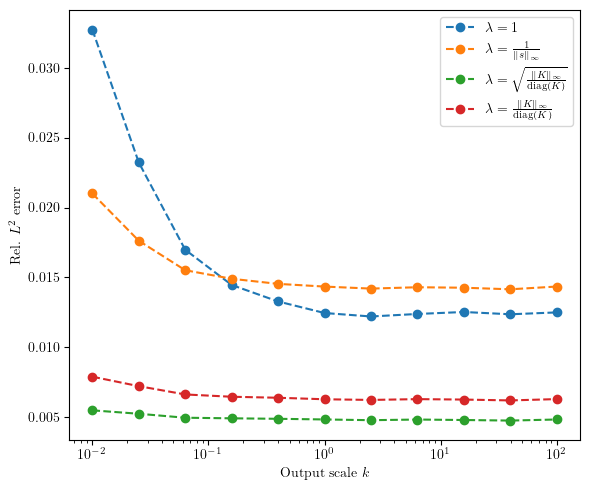

In [11]:
# Relative l2 errors
output_scale_list =  np.power(10, np.linspace(-2.0, 2.0, 11))

fig = plt.figure(figsize=(6,5))

for k in range(4):
    weights = weights_scheme[k]
    error_mean = outputs[weights]['error_mean']
    error_std = outputs[weights]['error_std']
    
    plt.plot(output_scale_list, error_mean, 'o--', label=labels[k])
    
plt.xscale('log')
plt.xlabel('Output scale $k$')
plt.ylabel('Rel. $L^2$ error')
plt.tight_layout()
plt.legend()
plt.show()